In [50]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

**生成随机数据**

In [20]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [25]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
#在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
#import sys
#sys.path.append("..")
#from d2lzh_pytorch import * 

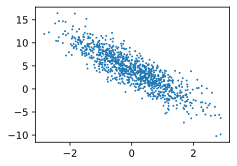

In [26]:
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [27]:
# read Data
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.3691,  0.6403],
        [ 1.3835, -0.1456],
        [ 0.5342, -0.6874],
        [-0.4763,  0.8660],
        [-0.8192,  2.3876],
        [ 0.1861, -0.4478],
        [-0.1214, -0.3865],
        [-1.1986,  0.1815],
        [ 0.4395, -0.2559],
        [-0.3594,  1.8888]]) tensor([ 1.2893,  7.4504,  7.6098,  0.2990, -5.5616,  6.0708,  5.2758,  1.1874,
         5.9468, -2.9582])


**神经网络模型**

初始化参数

In [29]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

**线性模型**

In [30]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

**损失函数**

In [31]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

**优化算法**

In [32]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

**训练模型**

In [33]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.042309
epoch 2, loss 0.000167
epoch 3, loss 0.000052


**简洁实现**

**数据加载**

In [34]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [36]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[-2.8727,  1.6901],
        [-0.6135, -0.4074],
        [ 2.0191, -0.3271],
        [-0.0768,  1.2785],
        [-1.2895,  0.1573],
        [-0.3319,  0.5452],
        [-0.3890, -0.7083],
        [ 0.3391,  1.1785],
        [-1.0642,  0.0988],
        [-0.0250, -1.8154]]) tensor([-7.2952,  4.3480,  9.3564, -0.3094,  1.0744,  1.6935,  5.8277,  0.8830,
         1.7539, 10.3014])


In [38]:
import torch.nn as nn

In [39]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


**神经网络的不同定义**

In [40]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


**可学习的参数**

In [41]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0657, -0.1487]], requires_grad=True)
Parameter containing:
tensor([-0.6477], requires_grad=True)


**初始化参数**

In [42]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

**损失函数**

In [43]:
loss = nn.MSELoss()

**优化算法**

In [44]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [45]:
optimizer =optim.SGD([
                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
                {'params': net.subnet1.parameters()}, # lr=0.03
                {'params': net.subnet2.parameters(), 'lr': 0.01}
            ], lr=0.03)

AttributeError: 'Sequential' object has no attribute 'subnet1'

**有时候我们不想让学习率固定成一个常数**

In [46]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍

**训练数据**

In [47]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 5.269745
epoch 2, loss: 3.490934
epoch 3, loss: 0.728688


**准确度**

In [49]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.6400, -2.8475]], requires_grad=True)
4.2 Parameter containing:
tensor([3.4548], requires_grad=True)
